# Лабораторная работа №2. Оптимальные портфели инвестиций. 

Выполнили студенты 19ПМИ-2: Созинов Кирилл, Матвеев Андрей, Иванов Даниил.



In [292]:
from mpl_toolkits.mplot3d.axes3d import math
!pip install yfinance > /dev/null
!pip install PyPortfolioOpt > /dev/null
from pypfopt import risk_models 
from pypfopt import expected_returns
import scipy.stats
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import time
import requests
import io
import os
import math
from scipy.stats import shapiro, normaltest, anderson
import seaborn as sns
from tqdm import tqdm_notebook
from scipy import optimize

## Загрузка данных

In [140]:
log_returns = pd.read_csv('log_returns.csv')

In [141]:
stats = pd.DataFrame(columns = ['Expected returns', 'Standard deviation'])
stats['Expected returns'] = log_returns.mean()
stats['Standard deviation'] = log_returns.std()
stats

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


,Expected returns,Standard deviation
3IN,0.000758,0.008050
888,-0.001853,0.021774
AAIF,-0.000280,0.010566
AAL,0.000566,0.022364
AAS,-0.000114,0.009960
...,...,...
WWH,-0.000227,0.011628
XAR,-0.003489,0.038060
XPP,-0.001775,0.018614
XPS,-0.000405,0.019001


## Задание 1. Efficient frontier.

1. Efficient frontier. Выбрать на рынке набор из 50 акций.  Объясните ваш выбор. Построить 
эффективный фронт портфелей инвестиций без ограничений на короткие позиции и  эффективный 
фронт с запретом коротких позиций. Сравнить эффективные фронты и сделать выводы.  При 
построении эффективных фронтов вычислить портфели с минимальным риском и отметить их на 
соответствующем эффективном фронте. Рассмотреть портфель  с равными долями вложения 
капитала и оценить, как  далек этот портфель от эффективного фронта. Тот же вопрос для индекса 
рынка.

Для определения наиболее предпочтительных акций используем **коэффициент Шарпа (sharp ratio)**

Скачиваем данные для нахождения мат. ожидания безрисковой акции (годовая гос. облигация)

In [142]:
bonds = pd.read_csv('bonds.csv')
bonds.set_index('Дата', inplace=True)
bonds.drop(columns = ['Цена', 'Макс.', 'Мин.', 'Изм. %'], inplace=True)
bonds_l = bonds['Откр.'].tolist()
bonds_l = [i.replace(',', '.') for i in bonds_l]
bonds_l = pd.Series(bonds_l)
#bonds = bonds.append(bonds_l.T, ignore_index=True)
#bonds['Open'] = bonds_l
#bonds.drop(['Откр.'])
bonds_l = bonds_l.iloc[::-1].astype(float)
bonds_returns = np.log(bonds_l / bonds_l.shift(1)).dropna()
Ef = bonds_returns.mean()
Ef

0.002467849288344735

In [143]:
stats['Sharp Ratio'] = (log_returns.mean() - Ef) / log_returns.std()
stats50 = stats.sort_values(by=['Sharp Ratio'], ascending=False)
stats50 = stats50.head(50)
stats50

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,Expected returns,Standard deviation,Sharp Ratio
PNL,0.006683,0.053384,0.078959
OCDO,0.002674,0.038284,0.005393
PLUS,0.002403,0.032382,-0.002014
GFRD,0.001622,0.053288,-0.015880
NANO,0.001548,0.039311,-0.023408
HIK,0.001741,0.025855,-0.028100
ZTF,0.001764,0.018678,-0.037664
DEC,0.001494,0.025162,-0.038713
OXB,0.001243,0.029698,-0.041251
FUTR,0.001091,0.028295,-0.048668


In [144]:
def plot_mean_var_map(df,x='Standard deviation', y='Expected returns', title='', figsize=(12, 6)):
    ax = df.plot(x=x, y=y, s = [100],
                          kind='scatter', 
                          figsize=figsize, 
                          edgecolor='black',
                          grid=True)
    plt.xlabel('Sigma', size=15)
    plt.ylabel('E', size=15)
    plt.title(title, size=16)

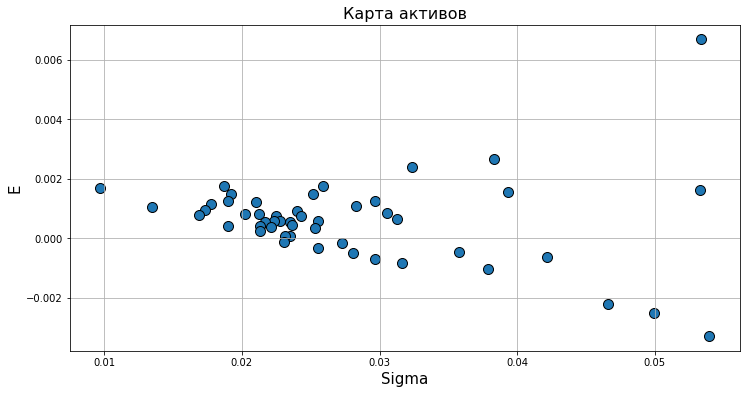

In [145]:
plot_mean_var_map(stats50, title='Карта активов')

In [146]:
log_returns

,Date,3IN,888,AAIF,AAL,AAS,ABD,ABDN,ABF,ACIC,...,WIZZ,WKP,WPP,WTAN,WTB,WWH,XAR,XPP,XPS,ZTF
0,2018-01-03 00:00:00+00:00,0.009500,0.006449,0.006889,-0.008057,0.009434,0.004149,-0.006840,0.020656,0.011209,...,-0.002165,0.007114,-0.025385,0.005561,0.001007,0.007905,0.006901,0.014389,0.002635,0.008762
1,2018-01-04 00:00:00+00:00,0.002360,0.000714,0.013637,0.014307,0.002345,0.010341,0.012700,0.001761,0.009509,...,-0.020523,-0.001013,0.012204,0.011030,0.006771,0.007843,0.002747,0.028171,-0.007926,-0.005467
2,2018-01-05 00:00:00+00:00,0.007050,0.007821,0.004505,-0.000997,-0.002345,0.004107,-0.000467,0.013976,0.014096,...,0.011818,0.026508,0.015423,0.003650,-0.001751,0.005842,0.031063,0.000000,0.002649,0.009820
3,2018-01-08 00:00:00+00:00,0.002342,-0.009249,0.011173,0.014611,0.000000,0.004090,0.010235,-0.010464,0.000000,...,0.002183,0.002957,-0.007870,0.000000,-0.009560,-0.007797,0.075532,0.013794,-0.002649,0.002169
4,2018-01-09 00:00:00+00:00,0.002333,0.015603,-0.004454,0.030269,-0.004706,0.004073,0.006689,-0.003513,0.000000,...,-0.004098,-0.005923,0.008243,0.005450,-0.003292,0.017459,-0.026235,-0.002744,0.002649,-0.017487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2018-12-20 00:00:00+00:00,0.015165,-0.037571,-0.002601,-0.028820,0.010050,-0.004556,0.003379,-0.003298,-0.005753,...,-0.004351,-0.013088,-0.028882,-0.021528,0.000896,-0.024541,-0.013245,0.018780,0.012579,0.020409
247,2018-12-21 00:00:00+00:00,0.003993,-0.028399,0.015504,0.028021,0.000000,-0.004577,0.013796,0.004238,-0.007722,...,0.002903,-0.019347,-0.002079,0.005168,-0.001792,-0.014599,0.000000,-0.009346,0.033797,0.093165
248,2018-12-24 00:00:00+00:00,-0.006091,-0.053121,-0.012903,-0.007104,-0.012073,0.009132,-0.016777,-0.022815,0.000000,...,-0.004357,-0.036051,-0.017493,-0.021887,0.013139,-0.012685,-0.052251,-0.018958,-0.033797,0.012195
249,2018-12-27 00:00:00+00:00,-0.006512,0.014158,-0.007823,-0.014479,0.022023,-0.013730,-0.003190,-0.018928,-0.005831,...,-0.009506,-0.000633,-0.023570,-0.001054,-0.010006,-0.010695,0.016466,0.028304,0.015504,0.003026


In [147]:
log_returns50 = log_returns[stats50.index]
log_returns50

,PNL,OCDO,PLUS,GFRD,NANO,HIK,ZTF,DEC,OXB,FUTR,...,IPF,PSON,CAPD,GNC,RCH,IWG,CPI,HNE,TTG,DSCV
0,0.000000,0.074836,0.221440,0.010035,0.011606,0.004951,0.008762,0.012626,-0.013882,0.000000,...,-0.023495,0.002176,0.0,-0.012579,0.032023,0.015957,-0.027948,0.002077,0.020112,0.010695
1,0.003665,0.034390,0.060838,0.005362,0.011472,0.000898,-0.005467,0.009988,0.068563,-0.018780,...,0.011567,-0.003265,0.0,0.009001,-0.018349,0.001929,0.039105,0.006205,0.004415,0.010582
2,0.001219,-0.001371,-0.015518,0.006852,0.053667,0.012926,0.009820,0.000000,0.071667,-0.016727,...,0.029559,0.001906,0.0,0.005808,0.012270,0.005764,0.021003,0.008214,0.004396,0.009168
3,-0.002439,-0.018934,-0.010480,-0.009912,-0.010870,-0.045298,0.002169,-0.006231,0.034898,0.014354,...,-0.009756,-0.010116,0.0,-0.030758,-0.007344,-0.000767,-0.036315,0.002043,0.006557,0.001303
4,0.000000,-0.010781,-0.005282,-0.004608,0.018051,-0.003714,-0.017487,0.006231,-0.012716,-0.004762,...,0.000000,0.014189,0.0,-0.000919,0.007344,0.006878,0.001224,-0.002043,-0.002181,0.012937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,-0.001268,-0.030009,-0.031480,0.021868,-0.002670,-0.047787,0.020409,-0.004454,-0.016727,-0.008247,...,-0.033799,-0.005559,0.0,0.069796,-0.020109,-0.012720,0.005962,-0.004963,0.020223,0.004686
247,0.000000,0.019153,0.001559,-0.009193,-0.027102,-0.053182,0.093165,0.026433,-0.028465,0.012346,...,-0.011871,-0.006669,0.0,0.005323,-0.004699,0.018537,-0.017063,-0.023151,-0.043997,-0.007823
248,-0.012771,-0.005995,0.013921,-0.000840,0.056089,0.018731,0.012195,-0.013129,-0.017195,0.000000,...,0.005179,0.001725,0.0,-0.004200,0.024808,-0.016570,-0.006533,0.000000,0.000000,-0.031918
249,0.000000,-0.020069,0.026527,-0.031585,-0.019673,-0.013343,0.003026,0.013129,0.000625,-0.031155,...,0.003094,-0.013886,0.0,-0.012422,-0.006145,-0.018349,-0.043537,-0.008180,0.001045,-0.016349


In [148]:
cov_matrix = log_returns50.cov().values
cov_matrix

array([[ 2.84983505e-03, -1.75154897e-05,  6.60909384e-05, ...,
        -8.55018817e-05,  3.38149589e-05,  8.38916232e-05],
       [-1.75154897e-05,  1.46567815e-03,  1.24630363e-04, ...,
         6.24919008e-05,  1.46907795e-04,  5.94003534e-05],
       [ 6.60909384e-05,  1.24630363e-04,  1.04860000e-03, ...,
         1.94057081e-05,  1.01403963e-04,  3.15321314e-05],
       ...,
       [-8.55018817e-05,  6.24919008e-05,  1.94057081e-05, ...,
         3.59566659e-04,  8.18108277e-05,  1.29923550e-04],
       [ 3.38149589e-05,  1.46907795e-04,  1.01403963e-04, ...,
         8.18108277e-05,  6.50722115e-04,  1.03120558e-04],
       [ 8.38916232e-05,  5.94003534e-05,  3.15321314e-05, ...,
         1.29923550e-04,  1.03120558e-04,  5.30550084e-04]])

In [149]:

def risk_porfolio(X, cov_matrix, n_observations=1, sqrt=True):
    # риск портфеля
    if sqrt:
        return np.sqrt(np.dot(np.dot(X, cov_matrix), X.T))
    else:
        return np.dot(np.dot(X, cov_matrix), X.T) / np.sqrt(n_observations)

def optimize_portfolio(risk_porfolio,
                       returns,
                       mean_returns, 
                       cov_matrix, 
                       bounds,
                       target_return=None):
    
    # оптимизатор с итеративным методом МНК SLSQP
    # решает задачу мимнимизации уравнения Лагранжа 
    
    X = np.ones(returns.shape[1])
    X = X / X.sum()
    bounds = bounds * returns.shape[1]

    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    if target_return:
        constraints.append({'type': 'eq', 
                            'args': (mean_returns,), 
                            'fun': lambda X, mean_returns: portfolio_return - np.dot(X, mean_returns)})

    return minimize(risk_porfolio, X,
                    args=(cov_matrix, returns.shape[0]), 
                    method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x

In [150]:
psigmas = []
preturns = []
bounds = ((None, None),) 
r_matrix, mean_vec, cov_matrix = log_returns50.values, log_returns50.mean().values, cov_matrix


X_min_risk = optimize_portfolio(risk_porfolio,
                                r_matrix,
                                mean_vec,
                                cov_matrix,
                                bounds)
min_risk = risk_porfolio(X_min_risk, cov_matrix)#, sqrt=True)
min_risk_preturn = np.dot(X_min_risk, mean_vec)
target_range = np.linspace(min_risk_preturn, 0.05, 300)
    
for portfolio_return in tqdm_notebook(target_range):
    X = optimize_portfolio(risk_porfolio,
                           r_matrix,
                           mean_vec,
                           cov_matrix,
                           bounds,
                           target_return=portfolio_return)
    psigmas.append(risk_porfolio(X, cov_matrix))#, sqrt=True))
    preturns.append(np.dot(X, mean_vec))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/300 [00:00<?, ?it/s]

In [151]:
pairs = sorted([(psigmas[i], preturns[i]) for i in range(len(psigmas))], key = lambda x: x[0])
pairs = pairs[:100]
psigmas_new, preturns_new = list(map(list, zip(*pairs)))

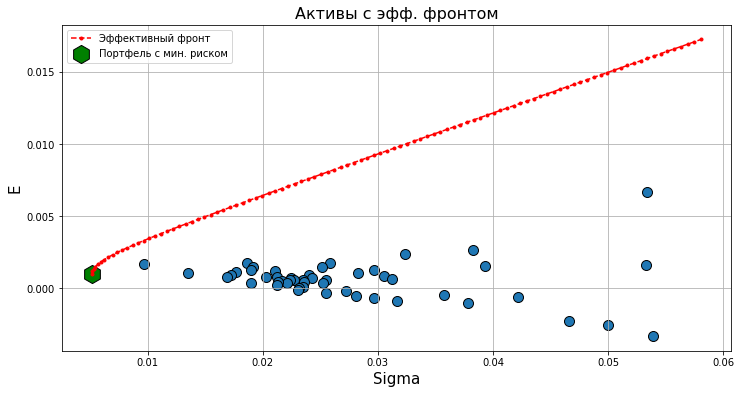

In [152]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk, 
            min_risk_preturn, 
            c='green',
            marker='h',
            s=330, 
            label='Портфель с мин. риском', 
            edgecolors='black',)
plt.plot(psigmas_new, preturns_new, 'r.--', label='Эффективный фронт')
plt.legend()
plt.show()

In [153]:
psigmas_ns = []
preturns_ns = []
bounds = ((0.0, 1.0),) 
r_matrix, mean_vec, cov_matrix = log_returns50.values, log_returns50.mean().values, cov_matrix


X_min_risk_ns = optimize_portfolio(risk_porfolio,
                                   r_matrix,
                                   mean_vec,
                                   cov_matrix,
                                   bounds)
min_risk_ns = risk_porfolio(X_min_risk_ns, cov_matrix)
min_risk_preturn_ns = np.dot(X_min_risk_ns, mean_vec)
target_range = np.linspace(min_risk_preturn_ns, 0.1, 500)


for portfolio_return in tqdm_notebook(target_range):
    X_ns = optimize_portfolio(risk_porfolio,
                                       r_matrix,
                                       mean_vec,
                                       cov_matrix,
                                       bounds, 
                                       target_return=portfolio_return)
    psigmas_ns.append(risk_porfolio(X_ns, cov_matrix))
    preturns_ns.append(np.dot(X_ns, mean_vec))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

In [186]:
len(target_range)

500

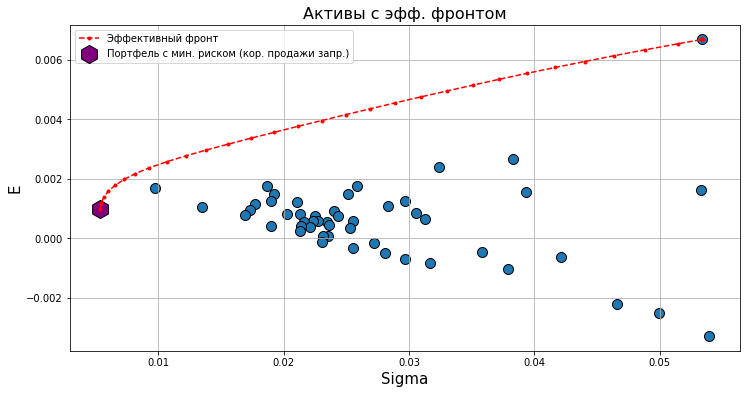

In [165]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk_ns, 
            min_risk_preturn_ns, 
            c='purple',
            marker='h',
            s=330, 
            label='Портфель с мин. риском (кор. продажи запр.)', 
            edgecolors='black',)
plt.plot(psigmas_ns, preturns_ns, 'r.--', label='Эффективный фронт')
plt.legend()
plt.show()

### Портфель с равными долями

In [155]:
N = 50
part = 1/50
expected_return_knapsack = 0
for i in range(N):
  expected_return_knapsack += stats50['Expected returns'][i] * part

expected_return_knapsack

0.0005910994691808234

In [156]:
returns_eqw = []
for index, row in log_returns50.iterrows():
    returns_eqw.append(np.sum(row)/N)

deviation_knapsack = 0
tickers = stats50.index
for i in range(N-1):
  for j in range(1, N):
    deviation_knapsack += part**2 * np.cov(log_returns50[tickers[i]].astype('float32'), log_returns50[tickers[j]].astype('float32'))[0][1]

deviation_knapsack = math.sqrt(deviation_knapsack)
deviation_knapsack

0.007683063167962495

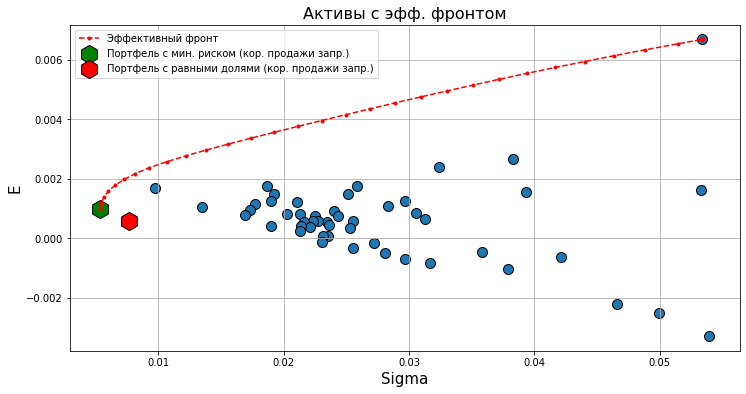

In [157]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk_ns, 
            min_risk_preturn_ns, 
            c='green',
            marker='h',
            s=330, 
            label='Портфель с мин. риском (кор. продажи запр.)', 
            edgecolors='black',)
plt.scatter(deviation_knapsack, expected_return_knapsack,
            c='red',
            marker='h',
            s=330,
            label='Портфель с равными долями (кор. продажи запр.)', 
            edgecolors='black',)
plt.plot(psigmas_ns, preturns_ns, 'r.--', label='Эффективный фронт')
plt.legend()
plt.show()

### Индекс рынка

In [158]:
start = datetime.datetime(2018,1,1)
end = datetime.datetime(2018,12,31)
market_index = yf.download('^FTSE', start=start, end=end, progress=False)
market_index['Name'] = '^FTSE'
market_index
market_index_edited = market_index.drop(columns = ['Low', 'High', 'Open', 'Close', 'Volume'])
market_index_edited
#market_index_edited.set_index(['Date'])

index_data = (market_index.assign(idx=market_index.groupby('Name').cumcount())
                 .pivot_table(index='Date', columns='Name', 
                              values='Adj Close', aggfunc='sum'))
index_data

Name,^FTSE
Date,
2018-01-02,7648.100098
2018-01-03,7671.100098
2018-01-04,7695.899902
2018-01-05,7724.200195
2018-01-08,7696.500000
...,...
2018-12-20,6711.899902
2018-12-21,6721.200195
2018-12-24,6686.000000


In [159]:
index_log_return = np.log(index_data['^FTSE'] / index_data['^FTSE'].shift(1))
index_log_return.drop(["2018-01-02"], inplace=True)
index_mean = index_log_return.mean()
index_deviation = index_log_return.std()
print(index_mean,'\n\n', index_deviation)

-0.0005071232789132974 

 0.008037053981426312


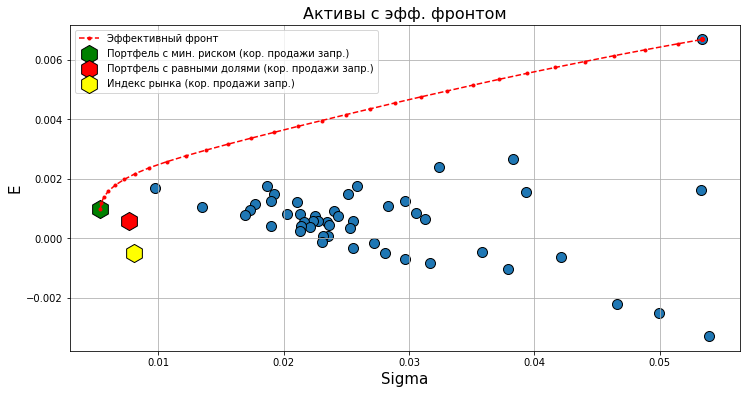

In [160]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk_ns, 
            min_risk_preturn_ns, 
            c='green',
            marker='h',
            s=330, 
            label='Портфель с мин. риском (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(deviation_knapsack, expected_return_knapsack,
            c='red',
            marker='h',
            s=330,
            label='Портфель с равными долями (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(index_deviation, index_mean,
            c='yellow',
            marker='h',
            s=330,
            label='Индекс рынка (кор. продажи запр.)', 
            edgecolors='black',)
plt.plot(psigmas_ns, preturns_ns, 'r.--', label='Эффективный фронт')

plt.legend()
plt.show()

Итоговые результаты:

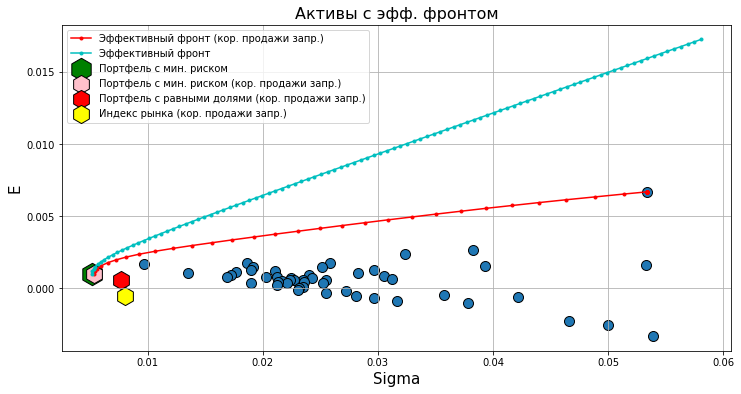

In [184]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk, 
            min_risk_preturn, 
            c='green',
            marker='h',
            s=500, 
            label='Портфель с мин. риском', 
            edgecolors='black',)

plt.scatter(min_risk_ns, 
            min_risk_preturn_ns, 
            c='pink',
            marker='h',
            s=330, 
            label='Портфель с мин. риском (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(deviation_knapsack, expected_return_knapsack,
            c='red',
            marker='h',
            s=330,
            label='Портфель с равными долями (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(index_deviation, index_mean,
            c='yellow',
            marker='h',
            s=330,
            label='Индекс рынка (кор. продажи запр.)', 
            edgecolors='black',)
plt.plot(psigmas_ns, preturns_ns,'r.-',  label='Эффективный фронт (кор. продажи запр.)')
plt.plot(psigmas_new, preturns_new,  'c.-', label='Эффективный фронт')
plt.legend()
plt.show()

## Задание 2. Portfolio selection problem.

2. Portfolio selection problem. Требуется построить «хорошие» инвестиционные портфели из 10 
активов вместо исходных 50 (или даже всех активов рынка). Предложите способ выбрать 10 активов 
(из отобранных ранее 50) для формирования портфеля. Сравните эффективные фронты всего набора 
(50 акций)  и выбранного набора активов (10 акций) для двух случаев
- короткие продажи разрешены, 
- короткие продажи запрещены.

In [187]:
stats10 = stats.sort_values(by=['Sharp Ratio'], ascending=False)
stats10 = stats10.head(10)
stats10

,Expected returns,Standard deviation,Sharp Ratio
PNL,0.006683,0.053384,0.078959
OCDO,0.002674,0.038284,0.005393
PLUS,0.002403,0.032382,-0.002014
GFRD,0.001622,0.053288,-0.015880
NANO,0.001548,0.039311,-0.023408
HIK,0.001741,0.025855,-0.028100
ZTF,0.001764,0.018678,-0.037664
DEC,0.001494,0.025162,-0.038713
OXB,0.001243,0.029698,-0.041251
FUTR,0.001091,0.028295,-0.048668


In [191]:
log_returns10 = log_returns50[stats10.index]
cov_matrix10 = log_returns10.cov().values

In [192]:
psigmas10 = []
preturns10 = []
bounds = ((None, None),) 
r_matrix, mean_vec, cov_matrix = log_returns10.values, log_returns10.mean().values, cov_matrix10


X_min_risk_10 = optimize_portfolio(risk_porfolio,
                                r_matrix,
                                mean_vec,
                                cov_matrix,
                                bounds)
min_risk_10 = risk_porfolio(X_min_risk_10, cov_matrix)#, sqrt=True)
min_risk_preturn_10 = np.dot(X_min_risk_10, mean_vec)
target_range = np.linspace(min_risk_preturn_10, 0.05, 500)
    
for portfolio_return in tqdm_notebook(target_range):
    X = optimize_portfolio(risk_porfolio,
                           r_matrix,
                           mean_vec,
                           cov_matrix,
                           bounds,
                           target_return=portfolio_return)
    psigmas10.append(risk_porfolio(X, cov_matrix))#, sqrt=True))
    preturns10.append(np.dot(X, mean_vec))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/500 [00:00<?, ?it/s]

In [195]:
psigmas_ns_10 = []
preturns_ns_10 = []
bounds = ((0.0, 1.0),) 
r_matrix, mean_vec, cov_matrix = log_returns10.values, log_returns10.mean().values, cov_matrix


X_min_risk_ns_10 = optimize_portfolio(risk_porfolio,
                                   r_matrix,
                                   mean_vec,
                                   cov_matrix,
                                   bounds)
min_risk_ns_10 = risk_porfolio(X_min_risk_ns_10, cov_matrix)
min_risk_preturn_ns_10 = np.dot(X_min_risk_ns_10, mean_vec)
target_range = np.linspace(min_risk_preturn_ns_10, 0.05, 500)


for portfolio_return in tqdm_notebook(target_range):
    X_ns = optimize_portfolio(risk_porfolio,
                                       r_matrix,
                                       mean_vec,
                                       cov_matrix,
                                       bounds, 
                                       target_return=portfolio_return)
    psigmas_ns_10.append(risk_porfolio(X_ns, cov_matrix))
    preturns_ns_10.append(np.dot(X_ns, mean_vec))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

In [199]:
# Режем масштаб
pairs10 = sorted([(psigmas10[i], preturns10[i]) for i in range(len(psigmas10))], key = lambda x: x[0])
pairs10 = pairs10[:70]
psigmas_new10, preturns_new10 = list(map(list, zip(*pairs10)))

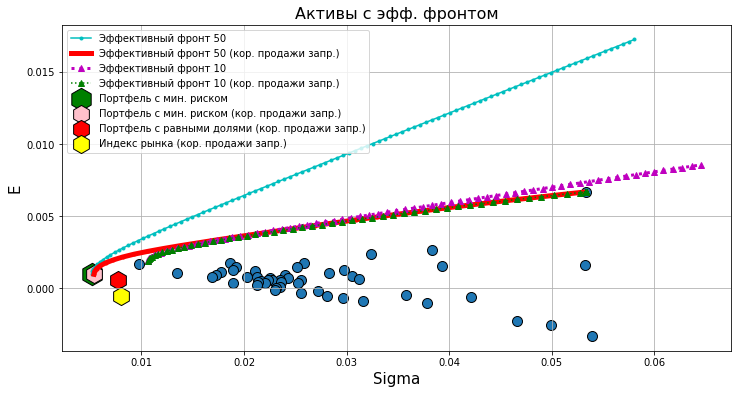

In [216]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk, 
            min_risk_preturn, 
            c='green',
            marker='h',
            s=500, 
            label='Портфель с мин. риском', 
            edgecolors='black',)

plt.scatter(min_risk_ns, 
            min_risk_preturn_ns, 
            c='pink',
            marker='h',
            s=330, 
            label='Портфель с мин. риском (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(deviation_knapsack, expected_return_knapsack,
            c='red',
            marker='h',
            s=330,
            label='Портфель с равными долями (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(index_deviation, index_mean,
            c='yellow',
            marker='h',
            s=330,
            label='Индекс рынка (кор. продажи запр.)', 
            edgecolors='black',)
plt.plot(psigmas_new, preturns_new,  'c.-', label='Эффективный фронт 50')
plt.plot(psigmas_ns, preturns_ns,'r.-',  label='Эффективный фронт 50 (кор. продажи запр.)', linewidth=5.0)
plt.plot(psigmas_new10, preturns_new10,  '^m:', label='Эффективный фронт 10', linewidth=3.0)
plt.plot(psigmas_ns_10, preturns_ns_10,  '^g:', label='Эффективный фронт 10 (кор. продажи запр.)')
plt.legend()
plt.show()

## Задание 3. Risk aversion.

Оцените свое отношение к риску и постройте свой личный оптимальный портфель 
инвестиций из выбранных 50 активов.  Дайте характеристику портфеля по составу и долям активов. 
Оцените VaR доходностей портфеля. Рассмотрите два случая: 
- короткие продажи разрешены, 
- короткие продажи запрещены.

In [287]:
from scipy import stats

def objective_function(X, returns, risk_level, cov_matrix):
    # risk_level is alpha
    return - np.dot(returns, X) + risk_level * risk_porfolio(X, cov_matrix)
    
def optimize_risk_aversion_portfolio(objective_function, returns, cov_matrix, risk_level, bounds, N):
    X = np.ones(N)
    X = X / X.sum()
    bounds = bounds * N
    
    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    
    return minimize(objective_function, X,
                    args=(returns, risk_level, cov_matrix), method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x
    
def risk_aversion_computing(params_, sse_components=False):
    min_risk, min_risk_preturn, losses = [], [], {}
    N = params_['data'].shape[1]
    E = stats10['Expected returns'].values
    r_matrix, mean_vec, cov_matrix = params_['data'].values, params_['data'].mean().values, params_['data'].cov().values
    X_min_risks = []
    bounds = ((-1, 1),) if params_['short'] else ((0, 1),)
    for risk_level in params_['risk_levels']:
        X_min_risk = optimize_risk_aversion_portfolio(objective_function, E, cov_matrix, 
                                                      risk_level, bounds, N)
        min_risk.append(risk_porfolio(X_min_risk, cov_matrix))
        min_risk_preturn.append(np.dot(X_min_risk, E))
        losses[risk_level] = - np.dot(r_matrix,X_min_risk)
        X_min_risks.append(X_min_risk)
    return min_risk, min_risk_preturn, losses, X_min_risks

def plot_risk_aversion_method(params_, min_risk_, min_risk_preturn_, short=False):
    plot_mean_var_map(stats50, title='Карта активов')
    short_sales_word = 'разрешением коротких продаж с alpha = ' if short else 'запретом коротких продаж alpha = '

    for ind, risk_level in enumerate(params_['risk_levels']):
        plt.scatter(min_risk_[ind], min_risk_preturn_[ind],
                marker='*', s=300, edgecolors='black', label = 'Портфель с '+short_sales_word+str(risk_level))
    plt.legend()
    plt.show()

In [274]:
params_50 = {}
min_risk, min_risk_preturn = [], []
params_50['short'] = True
params_50['data'] = log_returns50
params_50['risk_levels'] = [0.3, 1, 2.5, 5] # к-т отвращения к риску
#params_50['risk_levels'] = np.linspace(1, 5, 5)
losses = {} # вычислим потери как минус лог. доходности

min_risk, min_risk_preturn, losses, X_mins_ = risk_aversion_computing(params_50, sse_components=True)

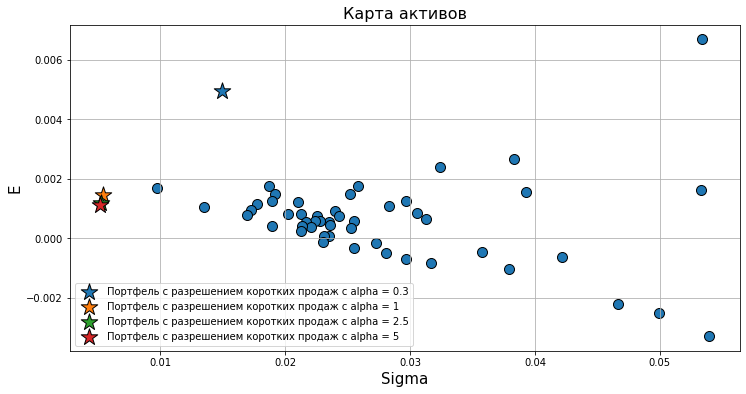

In [275]:
plot_risk_aversion_method(params_50, min_risk, min_risk_preturn, True)

In [282]:
from scipy.stats import norm

def VaR_info(risk_levels_, losses_):
    confidence_lvl = [0.9, 0.95, 0.99]
    VaR = {}
    for risk_level in risk_levels_:
        print('VaR характеристика для портфеля с уровнем отвращения к риску %s:' % risk_level)
        for clvl in confidence_lvl:
            loss = losses_[risk_level]
            loss = loss[np.isfinite(loss)]
            VaR[clvl] = np.quantile(loss, clvl)
            print(' - Потери не превысят %.4f%s с %.2f%s уверенностью.' % (np.round(VaR[clvl],4)*100,'%', clvl, '%'))
            
VaR_info(params_50['risk_levels'], losses)

VaR характеристика для портфеля с уровнем отвращения к риску 0.3:
 - Потери не превысят 1.0800% с 0.90% уверенностью.
 - Потери не превысят 1.6800% с 0.95% уверенностью.
 - Потери не превысят 2.6900% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 1:
 - Потери не превысят 0.4600% с 0.90% уверенностью.
 - Потери не превысят 0.6100% с 0.95% уверенностью.
 - Потери не превысят 1.4100% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 2.5:
 - Потери не превысят 0.4600% с 0.90% уверенностью.
 - Потери не превысят 0.6500% с 0.95% уверенностью.
 - Потери не превысят 1.4000% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 5:
 - Потери не превысят 0.4800% с 0.90% уверенностью.
 - Потери не превысят 0.6600% с 0.95% уверенностью.
 - Потери не превысят 1.3900% с 0.99% уверенностью.


Запрещаем короткие продажи:

In [283]:
params_50_no_short = params_50
params_50_no_short['short'] = False
losses_no_short = {} # вычислим потери как минус лог. доходности
min_risk_no_short, min_risk_preturn_no_short = [], []

min_risk_no_short, min_risk_preturn_no_short, losses_no_short, X_mins_50_ns = risk_aversion_computing(params_50_no_short, 
                                                                                        sse_components=True)

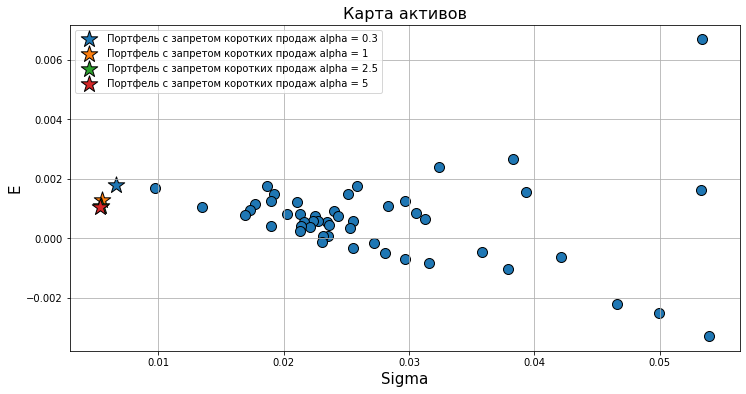

In [284]:
plot_risk_aversion_method(params_50_no_short, min_risk_no_short, min_risk_preturn_no_short, short=False)

In [285]:
VaR_info(params_50_no_short['risk_levels'], losses_no_short)

VaR характеристика для портфеля с уровнем отвращения к риску 0.3:
 - Потери не превысят 0.4700% с 0.90% уверенностью.
 - Потери не превысят 0.6300% с 0.95% уверенностью.
 - Потери не превысят 1.4900% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 1:
 - Потери не превысят 0.4200% с 0.90% уверенностью.
 - Потери не превысят 0.6400% с 0.95% уверенностью.
 - Потери не превысят 1.4000% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 2.5:
 - Потери не превысят 0.4600% с 0.90% уверенностью.
 - Потери не превысят 0.6300% с 0.95% уверенностью.
 - Потери не превысят 1.3200% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 5:
 - Потери не превысят 0.4700% с 0.90% уверенностью.
 - Потери не превысят 0.6400% с 0.95% уверенностью.
 - Потери не превысят 1.2900% с 0.99% уверенностью.


## Задание 4. Risk aversion and Portfolio selection.
Используя выбранное  в п.3 отношение к риску постройте  
оптимальный портфель из 10 активов (вместо 50, см. п.2). Дайте характеристику этого портфеля по 
составу активов и долям инвестиций. Сравните с портфелем п.3. Оцените VaR доходностей 
портфеля. Рассмотрите два случая: 
- короткие продажи разрешены, 
- короткие продажи запрещены.
Можно ли ваш портфель из 10 активов улучшить, оставаясь в рамках 10 активов из выбранных ранее 
50 активов?

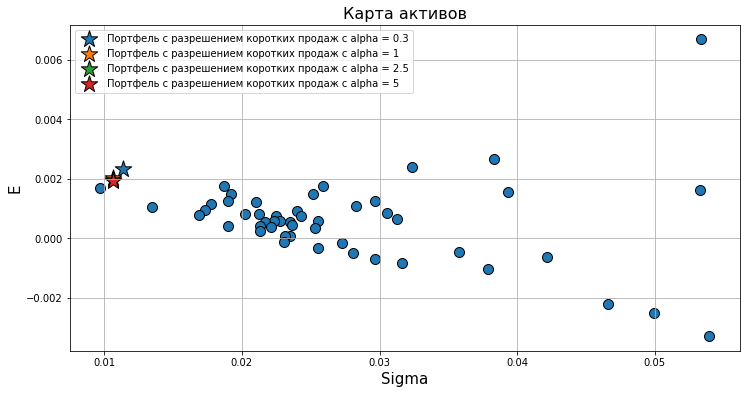

In [288]:
params_10 = params_50
params_10['short'] = True
params_10['data'] = log_returns10
losses, min_risk_10, min_risk_preturn = {}, [], []

min_risk_10, min_risk_preturn, losses_10, X_mins_10 = risk_aversion_computing(params_10)
plot_risk_aversion_method(params_10, min_risk_10, min_risk_preturn, short=True)

In [289]:
VaR_info(params_10['risk_levels'], losses_10)

VaR характеристика для портфеля с уровнем отвращения к риску 0.3:
 - Потери не превысят 0.9400% с 0.90% уверенностью.
 - Потери не превысят 1.4100% с 0.95% уверенностью.
 - Потери не превысят 2.3700% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 1:
 - Потери не превысят 1.0100% с 0.90% уверенностью.
 - Потери не превысят 1.4800% с 0.95% уверенностью.
 - Потери не превысят 2.5500% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 2.5:
 - Потери не превысят 1.0000% с 0.90% уверенностью.
 - Потери не превысят 1.5100% с 0.95% уверенностью.
 - Потери не превысят 2.5800% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 5:
 - Потери не превысят 1.0000% с 0.90% уверенностью.
 - Потери не превысят 1.5300% с 0.95% уверенностью.
 - Потери не превысят 2.5900% с 0.99% уверенностью.


Не шортим:

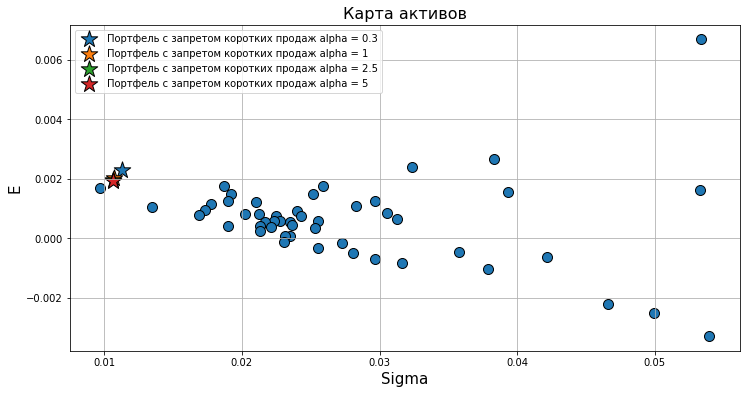

In [290]:
params_10_no_short = params_10
params_10_no_short['short'] = False
losses_ns, min_risk_ns, min_risk_preturn_ns = {}, [], []
min_risk_ns, min_risk_preturn_ns, losses_ns, X_mins_10_ns = risk_aversion_computing(params_10_no_short)
plot_risk_aversion_method(params_10_no_short, min_risk_ns, min_risk_preturn_ns, short=False)

In [291]:
VaR_info(params_10_no_short['risk_levels'], losses_ns)

VaR характеристика для портфеля с уровнем отвращения к риску 0.3:
 - Потери не превысят 0.9500% с 0.90% уверенностью.
 - Потери не превысят 1.4400% с 0.95% уверенностью.
 - Потери не превысят 2.3200% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 1:
 - Потери не превысят 1.0300% с 0.90% уверенностью.
 - Потери не превысят 1.4800% с 0.95% уверенностью.
 - Потери не превысят 2.4900% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 2.5:
 - Потери не превысят 1.0000% с 0.90% уверенностью.
 - Потери не превысят 1.5200% с 0.95% уверенностью.
 - Потери не превысят 2.5100% с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 5:
 - Потери не превысят 0.9900% с 0.90% уверенностью.
 - Потери не превысят 1.5400% с 0.95% уверенностью.
 - Потери не превысят 2.5300% с 0.99% уверенностью.


## Задание 5. Markowitz-Tobin model.
Рассмотрите набор активов, отобранных в п.2 (10 активов).  Выберете  
безрисковый актив (можно виртуальный). Постройте рыночный (оптимальный)  портфель. Сделайте 
анализ долей активов рыночного портфеля. Оцените VaR доходностей портфеля. Рассмотрите два 
случая: 
- короткие продажи разрешены, 
- короткие продажи запрещены.

In [305]:
def objective_function(x, cov_matix, mean_vector, risk_free_mean):
    f = float(-(x.dot(mean_vector) - risk_free_mean) / np.sqrt(np.dot(np.dot(x, cov_matrix), x.T)))
    return f


def optimal_portfolio_sharp_ratio(profits, risk_free_mean, N, cov_matrix,returns,bounds):
    X = np.ones(N)
    X = X / X.sum()
    bounds = bounds * N
    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    minimize = optimize.minimize(objective_function, X,
                    args=(cov_matrix, returns, risk_free_mean,), method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x
    return minimize

def optimal_portfolio_computing(data,risk_free_asset, allow_short = False):
    results = {}
    risk_free_mean = risk_free_asset
    N = log_returns10.shape[1]
    r_matrix, cov_matrix = log_returns10.values, log_returns10.cov().values
    E = stats10['Expected returns'].values
    bounds = ((-1, 1),) if allow_short else ((0, 1),)
    optim_portfolio_weights =  optimal_portfolio_sharp_ratio(log_returns10, risk_free_mean,N,cov_matrix,E, bounds)
    results['optim_weights'] = optim_portfolio_weights
    results['best_sharp_sigma'] = risk_porfolio(optim_portfolio_weights, cov_matrix)
    results['best_sharp_return'] = np.dot(optim_portfolio_weights, E)
    results['losses'] = -np.dot(r_matrix, optim_portfolio_weights)
    return results

def plot_optimal_sharp_ratio_portfolio_method(data, best_sharp_sigma, best_sharp_return, short=False):
    plot_mean_var_map(data, title='Карта активов')
    short_sales_word = 'разрешением' if short else 'запретом'
    plt.scatter(best_sharp_sigma, best_sharp_return,
                marker='*', s=300, 
                label='Рыночный (оптимальный) портфель с ' + short_sales_word + ' коротких продаж', 
                edgecolors='red')
    plt.legend()
    plt.show()

In [312]:
short_results = optimal_portfolio_computing(log_returns10, Ef, allow_short=True)

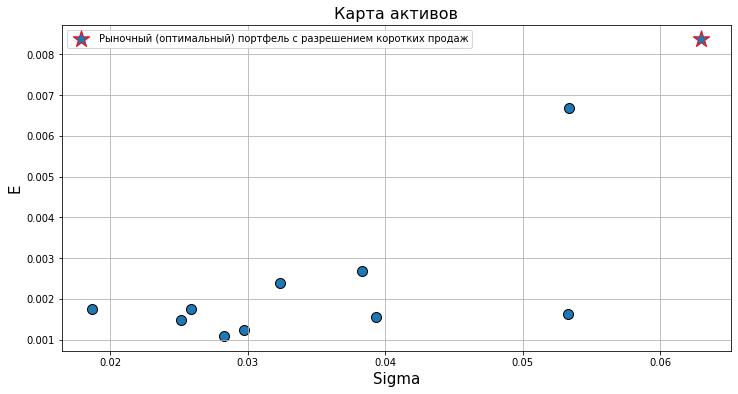

In [316]:
plot_optimal_sharp_ratio_portfolio_method(stats10, 
                                          short_results['best_sharp_sigma'],
                                          short_results['best_sharp_return'], 
                                          short=True)

Короткие запрещены:

In [313]:
long_results = optimal_portfolio_computing(log_returns10, Ef, allow_short=False)

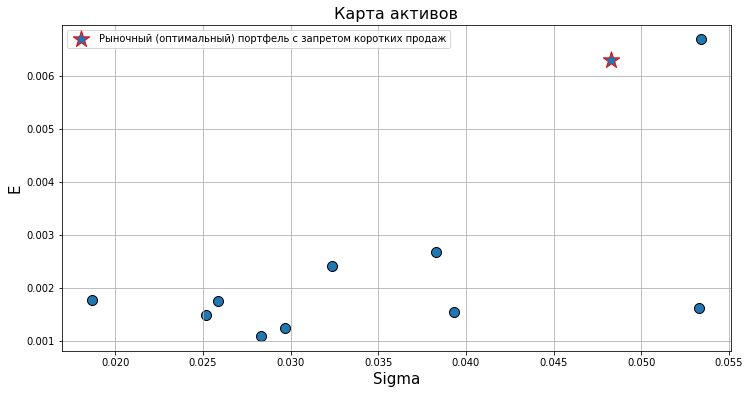

In [315]:
plot_optimal_sharp_ratio_portfolio_method(stats10, 
                                          long_results['best_sharp_sigma'],
                                          long_results['best_sharp_return'], 
                                          short=False)

In [321]:
def VaR_info(losses):
    confidence_lvl = [0.9, 0.95, 0.99]
    VaR = {}
    for clvl in confidence_lvl:
        loss = losses[np.isfinite(losses)]
        VaR[clvl] = np.quantile(loss, clvl)
        print(' - Потери не превысят %.4f%s с %.2f%s уверенностью.' % (VaR[clvl]*100, '%', clvl, '%'))

In [322]:
print('Короткие продажи разрешены')
VaR_info(short_results['losses'])

Короткие продажи разрешены
 - Потери не превысят 3.6854% с 0.90% уверенностью.
 - Потери не превысят 4.7275% с 0.95% уверенностью.
 - Потери не превысят 7.3722% с 0.99% уверенностью.


In [323]:
print('Короткие продажи запрещены')
VaR_info(long_results['losses'])

Короткие продажи запрещены
 - Потери не превысят 0.5761% с 0.90% уверенностью.
 - Потери не превысят 0.8277% с 0.95% уверенностью.
 - Потери не превысят 1.1513% с 0.99% уверенностью.


фсе